<a href="https://colab.research.google.com/github/chan-kh/Music-Sentiment-Analysis/blob/main/LSTM_2outputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
import os
import datetime
from google.colab import drive

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.preprocessing import MinMaxScaler

from numpy import loadtxt
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

from keras import layers
from keras.optimizers import RMSprop
from keras.layers import Bidirectional

from math import sqrt
from scipy.stats.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [84]:
drive.mount("/content/drive")
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Sentiment/features_60frames_allsongs.csv')
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,song_id,frame_num,zcr,rms,spectral_centroid,spectral_bandwidth,spectral_rolloff,spectral_contrast,spectral_flatness,melspectrogram,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,chroma_stft_0,chroma_stft_1,chroma_stft_2,chroma_stft_3,chroma_stft_4,chroma_stft_5,chroma_stft_6,chroma_stft_7,chroma_stft_8,chroma_stft_9,chroma_stft_10,chroma_stft_11,chroma_cqt_0,chroma_cqt_1,chroma_cqt_2,chroma_cqt_3,chroma_cqt_4,chroma_cqt_5,chroma_cqt_6,chroma_cqt_7,chroma_cqt_8,chroma_cqt_9,chroma_cqt_10,chroma_cqt_11,chroma_cens_0,chroma_cens_1,chroma_cens_2,chroma_cens_3,chroma_cens_4,chroma_cens_5,chroma_cens_6,chroma_cens_7,chroma_cens_8,chroma_cens_9,chroma_cens_10,chroma_cens_11,tonnetz_0,tonnetz_1,tonnetz_2,tonnetz_3,tonnetz_4,tonnetz_5,valence,arousal
0,2,0,0.157715,0.000011,5604.262879,3246.069688,9549.975586,18.349374,0.283305,0.000000,-636.134705,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.654255,0.699066,0.261531,0.874848,1.000000,0.333313,0.812421,0.488101,0.413135,0.640419,0.671442,0.490904,0.725918,0.250459,0.284098,0.647150,0.349017,0.147453,0.501239,0.074669,0.070883,0.633342,0.184297,0.136420,0.700169,0.030602,0.209675,0.828279,0.124886,0.257948,1.000000,0.071105,0.309559,0.798000,0.076693,0.276441,-0.134078,0.072852,-0.134683,0.086125,0.060471,0.042898,-0.073341,-0.109386
1,2,1,0.051758,0.096817,1443.667160,2057.611806,3036.181641,27.017306,0.003931,1.576688,-120.319748,129.464996,-4.253306,22.214062,8.163963,16.415987,15.152133,7.878392,-6.823561,-0.831550,-7.218902,-4.558928,-1.807601,12.948887,-9.162554,-3.758020,-5.506585,-1.227700,-4.439484,1.684063,0.528904,0.624552,0.263783,0.891966,0.850903,0.331133,1.000000,1.000000,0.408033,0.713866,0.681263,0.480444,0.245905,0.378263,0.278916,0.160639,0.397115,0.147040,0.285743,0.536704,0.072041,0.314144,0.652729,0.144099,0.269362,0.637670,0.218737,0.382769,0.677961,0.263132,0.424450,0.649488,0.317883,0.517798,0.579528,0.282752,-0.088692,0.052331,-0.112961,0.075804,0.041915,0.033029,-0.074661,-0.114942
2,2,2,0.101562,0.096426,2348.097128,2387.006355,4941.870117,22.434103,0.013857,0.152583,-107.915352,76.319107,-14.175928,45.124214,1.209538,7.516734,-5.023264,6.480774,-0.513962,8.108901,-0.198636,-3.022716,2.078595,4.819644,-16.200150,-3.348299,-5.746615,-9.680576,-17.688511,-5.846364,0.190785,0.290683,0.265836,0.206553,0.217986,0.329024,0.491271,0.576434,0.402986,1.000000,0.924618,0.469653,0.706139,0.605435,0.273279,0.307669,0.224213,0.146400,0.107266,0.206321,0.073380,0.222554,0.297425,0.151825,0.408395,0.409732,0.227828,0.563377,0.734764,0.268284,0.755202,1.000000,0.326054,0.528056,0.687259,0.288720,-0.034494,0.031843,-0.070020,0.068549,0.021691,0.023202,-0.074077,-0.116413
3,2,3,0.062500,0.086847,1692.187106,1872.280637,3219.213867,21.295763,0.004178,0.224268,-148.255432,121.565720,-36.703545,33.151939,4.518500,5.197342,-8.610166,4.267920,8.706326,-17.273952,-11.429454,4.515498,-7.324573,4.467141,-13.720921,-3.195490,-3.931114,-7.317858,-15.654930,-15.824336,0.245845,0.300974,0.267710,0.523842,0.578168,0.326966,1.000000,0.842026,0.397746,0.846539,1.000000,0.458391,0.477668,0.673670,0.267148,0.095004,0.189054,0.145584,0.031817,0.101448,0.075003,0.024125,0.114284,0.159790,0.044276,0.137589,0.237066,0.215029,0.300263,0.273559,0.177739,0.341496,0.334054,0.110806,0.207098,0.294537,-0.013095,0.020309,-0.055259,0.034349,0.011610,0.012032,-0.078154,-0.118613
4,2,4,0.120605,0.113167,2632.895857,2453.043616,5329.467773,18.914987,0.025196,1.035493,-71.919838,76.267471,-28.003765,15.988888,4.667567,35.548042,-6.664427,-5.128408,9.827440,-1.635414,-5.240368,-1.569069,-1.458279,7.581460,-16.175152,-6.295955,-9.435411,-3.781498,-8.782184,-7.635081,0.223808,0.355715,0.269517,0.202841,0.376315,0.324933,0.624933,0.684395,0.392219,1.000000,1.000000,0.446547,0.319092,0.

In [85]:
df.shape

(104640, 74)

In [86]:
df.pop('song_id')
df.pop('frame_num')

0          0
1          1
2          2
3          3
4          4
          ..
104635    55
104636    56
104637    57
104638    58
104639    59
Name: frame_num, Length: 104640, dtype: int64

In [87]:
y = df.loc[:,'valence':'arousal']
print(y.shape)
y.head()

(104640, 2)


,valence,arousal
0,-0.073341,-0.109386
1,-0.074661,-0.114942
2,-0.074077,-0.116413
3,-0.078154,-0.118613
4,-0.081588,-0.126457


In [88]:
df.pop('valence')
df.pop('arousal')

0        -0.109386
1        -0.114942
2        -0.116413
3        -0.118613
4        -0.126457
            ...   
104635    0.517000
104636    0.481000
104637    0.487000
104638    0.490000
104639    0.478000
Name: arousal, Length: 104640, dtype: float64

In [89]:
df.head()


,zcr,rms,spectral_centroid,spectral_bandwidth,spectral_rolloff,spectral_contrast,spectral_flatness,melspectrogram,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,chroma_stft_0,chroma_stft_1,chroma_stft_2,chroma_stft_3,chroma_stft_4,chroma_stft_5,chroma_stft_6,chroma_stft_7,chroma_stft_8,chroma_stft_9,chroma_stft_10,chroma_stft_11,chroma_cqt_0,chroma_cqt_1,chroma_cqt_2,chroma_cqt_3,chroma_cqt_4,chroma_cqt_5,chroma_cqt_6,chroma_cqt_7,chroma_cqt_8,chroma_cqt_9,chroma_cqt_10,chroma_cqt_11,chroma_cens_0,chroma_cens_1,chroma_cens_2,chroma_cens_3,chroma_cens_4,chroma_cens_5,chroma_cens_6,chroma_cens_7,chroma_cens_8,chroma_cens_9,chroma_cens_10,chroma_cens_11,tonnetz_0,tonnetz_1,tonnetz_2,tonnetz_3,tonnetz_4,tonnetz_5
0,0.157715,0.000011,5604.262879,3246.069688,9549.975586,18.349374,0.283305,0.000000,-636.134705,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.654255,0.699066,0.261531,0.874848,1.000000,0.333313,0.812421,0.488101,0.413135,0.640419,0.671442,0.490904,0.725918,0.250459,0.284098,0.647150,0.349017,0.147453,0.501239,0.074669,0.070883,0.633342,0.184297,0.136420,0.700169,0.030602,0.209675,0.828279,0.124886,0.257948,1.000000,0.071105,0.309559,0.798000,0.076693,0.276441,-0.134078,0.072852,-0.134683,0.086125,0.060471,0.042898
1,0.051758,0.096817,1443.667160,2057.611806,3036.181641,27.017306,0.003931,1.576688,-120.319748,129.464996,-4.253306,22.214062,8.163963,16.415987,15.152133,7.878392,-6.823561,-0.831550,-7.218902,-4.558928,-1.807601,12.948887,-9.162554,-3.758020,-5.506585,-1.227700,-4.439484,1.684063,0.528904,0.624552,0.263783,0.891966,0.850903,0.331133,1.000000,1.000000,0.408033,0.713866,0.681263,0.480444,0.245905,0.378263,0.278916,0.160639,0.397115,0.147040,0.285743,0.536704,0.072041,0.314144,0.652729,0.144099,0.269362,0.637670,0.218737,0.382769,0.677961,0.263132,0.424450,0.649488,0.317883,0.517798,0.579528,0.282752,-0.088692,0.052331,-0.112961,0.075804,0.041915,0.033029
2,0.101562,0.096426,2348.097128,2387.006355,4941.870117,22.434103,0.013857,0.152583,-107.915352,76.319107,-14.175928,45.124214,1.209538,7.516734,-5.023264,6.480774,-0.513962,8.108901,-0.198636,-3.022716,2.078595,4.819644,-16.200150,-3.348299,-5.746615,-9.680576,-17.688511,-5.846364,0.190785,0.290683,0.265836,0.206553,0.217986,0.329024,0.491271,0.576434,0.402986,1.000000,0.924618,0.469653,0.706139,0.605435,0.273279,0.307669,0.224213,0.146400,0.107266,0.206321,0.073380,0.222554,0.297425,0.151825,0.408395,0.409732,0.227828,0.563377,0.734764,0.268284,0.755202,1.000000,0.326054,0.528056,0.687259,0.288720,-0.034494,0.031843,-0.070020,0.068549,0.021691,0.023202
3,0.062500,0.086847,1692.187106,1872.280637,3219.213867,21.295763,0.004178,0.224268,-148.255432,121.565720,-36.703545,33.151939,4.518500,5.197342,-8.610166,4.267920,8.706326,-17.273952,-11.429454,4.515498,-7.324573,4.467141,-13.720921,-3.195490,-3.931114,-7.317858,-15.654930,-15.824336,0.245845,0.300974,0.267710,0.523842,0.578168,0.326966,1.000000,0.842026,0.397746,0.846539,1.000000,0.458391,0.477668,0.673670,0.267148,0.095004,0.189054,0.145584,0.031817,0.101448,0.075003,0.024125,0.114284,0.159790,0.044276,0.137589,0.237066,0.215029,0.300263,0.273559,0.177739,0.341496,0.334054,0.110806,0.207098,0.294537,-0.013095,0.020309,-0.055259,0.034349,0.011610,0.012032
4,0.120605,0.113167,2632.895857,2453.043616,5329.467773,18.914987,0.025196,1.035493,-71.919838,76.267471,-28.003765,15.988888,4.667567,35.548042,-6.664427,-5.128408,9.827440,-1.635414,-5.240368,-1.569069,-1.458279,7.581460,-16.175152,-6.295955,-9.435411,-3.781498,-8.782184,-7.635081,0.223808,0.355715,0.269517,0.202841,0.376315,0.324933,0.624933,0.684395,0.392219,1.000000,1.000000,0.446547,0.319092,0.448243,0.260494,0.103011,0.139945,0.144729,0.191945,0.245747,0.076884,0.266807,0.286048,0.167931,0.120557,0.326037,0.246430,0.267567,0

In [90]:
# df_mean = df.mean()
# df_std = df.std()

# df = (df - df_mean) / df_std


In [91]:
# print(type(df))

In [92]:
features = df.to_numpy()
y = y.to_numpy()

In [93]:
print(features.shape)
print(y.shape)

(104640, 70)
(104640, 2)


In [94]:
features = features.reshape(1744,60,70)
y = y.reshape(1744,60,2)

In [95]:
train_X , train_y = features[0:1220] , y[0:1220]
test_X , test_y = features[1220:1744] , y[1220:1744]
# val_X , val_y = features [1569:1744] , valence[0:1220]

In [96]:
print("train_X :" , train_X.shape , "train_y shape:" , train_y.shape)
print("test_X :" , test_X.shape , "test_y shape:" , test_y.shape)
# print("val_X :" , val_X.shape , "val_y shape:" , val_y.shape)


train_X : (1220, 60, 70) train_y shape: (1220, 60, 2)
test_X : (524, 60, 70) test_y shape: (524, 60, 2)


In [97]:
# print(features.shape)
# for i in range(1):
#   print(features)

In [98]:
# print(valence.shape)
# print(valence)

In [99]:
# print(type(features))
# print(features.shape)

In [100]:
model = Sequential()

# model.add(Bidirectional(LSTM(128,return_sequences=True, input_shape=(60,70))))
# model.add(Dropout(0.2))
# model.add(Bidirectional(LSTM(128,return_sequences=True, input_shape=(60,70))))
# model.add(Dropout(0.2))
# model.add(Bidirectional(LSTM(128,return_sequences=True, input_shape=(60,70))))
# model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(128,return_sequences=True, input_shape=(60,70))))
model.add(Bidirectional(LSTM(64,return_sequences=True, input_shape=(60,70))))
model.add(Bidirectional(LSTM(32,return_sequences=True, input_shape=(60,70))))
model.add(Bidirectional(LSTM(16,return_sequences=True, input_shape=(60,70))))
model.add(Bidirectional(LSTM(8,return_sequences=True, input_shape=(60,70))))




model.add(Dense(2))
model.compile(loss='mse', optimizer='adam')

In [101]:
history = model.fit(train_X, train_y, epochs=600, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/600
39/39 - 4s - loss: 0.0767 - val_loss: 0.0355
Epoch 2/600
39/39 - 1s - loss: 0.0588 - val_loss: 0.0344
Epoch 3/600
39/39 - 1s - loss: 0.0575 - val_loss: 0.0373
Epoch 4/600
39/39 - 1s - loss: 0.0569 - val_loss: 0.0345
Epoch 5/600
39/39 - 1s - loss: 0.0581 - val_loss: 0.0351
Epoch 6/600
39/39 - 1s - loss: 0.0541 - val_loss: 0.0367
Epoch 7/600
39/39 - 1s - loss: 0.0534 - val_loss: 0.0333
Epoch 8/600
39/39 - 1s - loss: 0.0525 - val_loss: 0.0338
Epoch 9/600
39/39 - 1s - loss: 0.0512 - val_loss: 0.0340
Epoch 10/600
39/39 - 1s - loss: 0.0537 - val_loss: 0.0346
Epoch 11/600
39/39 - 1s - loss: 0.0499 - val_loss: 0.0365
Epoch 12/600
39/39 - 1s - loss: 0.0528 - val_loss: 0.0339
Epoch 13/600
39/39 - 1s - loss: 0.0543 - val_loss: 0.0352
Epoch 14/600
39/39 - 1s - loss: 0.0565 - val_loss: 0.0347
Epoch 15/600
39/39 - 1s - loss: 0.0549 - val_loss: 0.0331
Epoch 16/600
39/39 - 1s - loss: 0.0532 - val_loss: 0.0316
Epoch 17/600
39/39 - 1s - loss: 0.0512 - val_loss: 0.0315
Epoch 18/600
39/39 - 1s

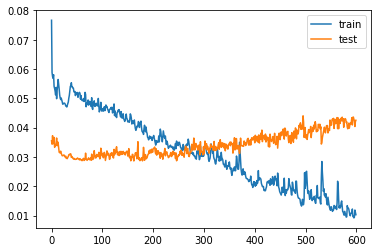

<Figure size 432x288 with 0 Axes>

In [102]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
plt.savefig("training loss 600epochs_5layers")

In [103]:
history.history
print('overall loss' , np.mean(history.history['loss']))
print('overall val_loss' , np.mean(history.history['val_loss']))

overall loss 0.03140968446154147
overall val_loss 0.034181296688814956


In [104]:
predicted_y = model.predict(test_X)


In [105]:
print(predicted_y.shape)
print(test_y.shape)

(524, 60, 2)
(524, 60, 2)


In [106]:
predicted_y = predicted_y.reshape(62880,)
test_y = test_y.reshape(62880,)

In [107]:
def metrics(y_true,y_pred,name):
  print(name,"")
  mae = mean_absolute_error(y_true,y_pred)
  rmse = sqrt(mean_squared_error(y_true,y_pred))
  r2 = r2_score(y_true,y_pred)
  pearson_corr = pearsonr(y_true,y_pred)
  spearman_corr = spearmanr(y_true,y_pred)
  print('MAE : ',mae)
  print('RMSE : ',rmse)
  print('R2 : ',r2)
  print('Pearson : ',pearson_corr)
  print('Spearman : ',spearman_corr,'\n')


In [108]:
def graph_results(x,y,title, xlim=-1, ylim=-1):
  #x and y are variables ( y_pred vs y_true )
  #Important
  plt.scatter(x,y,s=15)

  # if xlim != -1: plt.xlim([0, xlim])
  # if ylim != -1: plt.ylim([0, ylim])
  # plt.gca().set_ylim([1.5,7.5])
  # plt.gca().set_xlim([1.5,9])
  #Fix 
  plt.xlabel("Actual")
  plt.ylabel("Predicted")
  plt.title((title))
  # m, b = np.polyfit(x, y, 1)
  # plt.plot(x, m*x + b, color='red')  
  plt.savefig(title)

  plt.show()

valence & arousal 
MAE :  0.1579665359223032
RMSE :  0.2062499598721095
R2 :  0.0710075641575234
Pearson :  (0.5062559274812664, 0.0)
Spearman :  SpearmanrResult(correlation=0.5170825285658268, pvalue=0.0) 



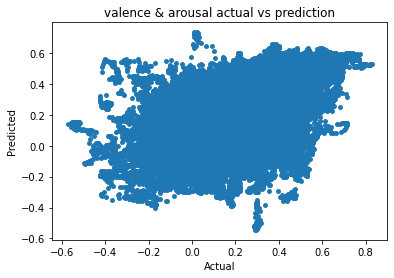

In [109]:
metrics(test_y,predicted_y,'valence & arousal')
graph_results(test_y,predicted_y,'valence & arousal actual vs prediction')
